## 🔄 Ajuste do Diretório de Trabalho

Antes de carregar ou manipular arquivos, é importante garantir que estamos no diretório correto do projeto.  
O código abaixo verifica se o notebook está sendo executado a partir da pasta `notebooks`. Se for o caso, ele sobe um nível na hierarquia de diretórios para garantir que o diretório de trabalho seja a raiz do projeto.

Isso é útil para manter caminhos relativos consistentes ao acessar dados, scripts ou outros recursos do projeto.

📌 **Resumo do que o código faz:**
- Verifica se o diretório atual termina com `notebooks`.
- Se sim, volta uma pasta (para a raiz do projeto).
- Exibe o novo diretório de trabalho.


In [4]:
import os

# Verifica se o diretório de trabalho atual termina com 'notebooks'
if os.path.basename(os.getcwd()) == 'notebooks':
    # Se sim, sobe um nível de diretório para a pasta raiz do projeto
    os.chdir('..')

# Imprime o diretório de trabalho para confirmar que a mudança foi feita
print(f"Diretório de Trabalho Atual: {os.getcwd()}")

Diretório de Trabalho Atual: c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov


## 📦 Carregamento das Bibliotecas para a Fase 3: Modelagem Preditiva

Nesta etapa, carregamos todas as bibliotecas necessárias para realizar o treinamento, validação e interpretação de modelos de Machine Learning aplicados à previsão da tendência do Ibovespa.

---

### 🔧 Principais Componentes Importados:

#### 📊 Manipulação de Dados
- `pandas`, `numpy`: Estruturação e transformação de dados tabulares e numéricos.
- `duckdb`: Consulta e carregamento eficiente da base persistida na fase anterior.

#### ⚙️ Modelagem e Avaliação
- `lightgbm`: Framework de gradient boosting eficiente, usado para modelagem supervisionada.
- `sklearn.model_selection.train_test_split`: Divisão da base de forma temporal para simular previsão realista.
- `sklearn.metrics`: Avaliação com métricas como `accuracy`, `ROC AUC`, `confusion_matrix`.

#### 🧠 Interpretação do Modelo
- `shap`: Framework de interpretabilidade para entender a importância das features no modelo treinado.

#### 📈 Visualização
- `matplotlib`, `seaborn`: Criação de gráficos e análise visual dos resultados.

#### 🛠️ Configuração do Projeto
- `src.config`: Importa o caminho e demais parâmetros definidos nas fases anteriores.

---

✅ Todas as bibliotecas e dependências da **Fase 3 - Modelagem** foram carregadas com sucesso e estão prontas para uso.


In [18]:
import duckdb
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split # Usaremos para a divisão temporal
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Importa nossas configurações de projeto
import src.config as config

# Helpers do Notebook
from IPython.display import display

# Configurações de estilo
sns.set_theme(style='whitegrid', palette='viridis')
plt.style.use("fivethirtyeight")
%matplotlib inline

print("✅ Bibliotecas para a Fase 3 carregadas com sucesso!")

✅ Bibliotecas para a Fase 3 carregadas com sucesso!


## 🧱 Carregamento dos Dados para Modelagem

Nesta etapa, buscamos no banco de dados DuckDB a tabela `features_completas`, que contém todas as variáveis criadas e tratadas na **Fase 2** do projeto. Esses dados são a base para o treinamento dos modelos de Machine Learning.

---

### 📥 Etapas Realizadas:

1. **Conexão ao Banco DuckDB**
   - Utilizamos o caminho salvo no módulo `config`.

2. **Leitura da Tabela `features_completas`**
   - A tabela contém os dados finais após a engenharia de atributos, com a variável `alvo` (target) já definida.

3. **Conversão da Coluna `data`**
   - A coluna `data` é convertida para o tipo `datetime` e definida como índice do DataFrame.
   - Essa configuração é fundamental para **garantir uma divisão temporal correta** entre treino e teste, evitando vazamento de dados.

---

✅ Ao final desta célula, temos o DataFrame `df_model` carregado, indexado por data e pronto para os próximos passos de preparação e modelagem.


In [14]:
# Carregando os dados da Fase 2 do nosso banco de dados

print(f"Carregando dados da tabela 'features_completas' de: {config.DB_PATH}")

try:
    con = duckdb.connect(database=str(config.DB_PATH), read_only=True)
    # MUITO IMPORTANTE: Selecionar da nova tabela com todas as features
    df_model = con.execute("SELECT * FROM features_completas").fetchdf()
    con.close()

    # Configura a coluna 'data' como o índice para facilitar a divisão temporal
    df_model['data'] = pd.to_datetime(df_model['data'])
    df_model.set_index('data', inplace=True)

    print("\n✅ Dados para modelagem carregados com sucesso!")
    print("Estrutura do DataFrame:")
    df_model.info()

except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")
    print("Verifique se o pipeline da Fase 1 e o notebook da Fase 2 foram executados com sucesso.")

Carregando dados da tabela 'features_completas' de: C:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\data\mercados.duckdb

✅ Dados para modelagem carregados com sucesso!
Estrutura do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2975 entries, 2014-02-05 to 2025-07-03
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   close_petroleo_brent             2975 non-null   float64
 1   close_petrobras                  2975 non-null   float64
 2   close_dolar                      2975 non-null   float64
 3   close_ibovespa                   2975 non-null   float64
 4   close_sp500                      2975 non-null   float64
 5   high_petroleo_brent              2975 non-null   float64
 6   high_petrobras                   2975 non-null   float64
 7   high_dolar                       2975 non-null   float64
 8   high_ibovespa                    2975 non-null   

## 🧮 Separação entre Features e Variável Alvo

Com os dados já carregados e indexados por data, o próximo passo é preparar os insumos para o modelo:

- **`X` (features):** contém todas as colunas explicativas, **excluindo a variável `alvo`**.
- **`y` (target):** representa a variável binária `alvo`, que indica se o Ibovespa **subirá (1)** ou **não subirá (0)** no dia seguinte.

---

### 📌 Objetivo
Essa separação é essencial para garantir que o modelo seja treinado apenas com variáveis **disponíveis até o dia da previsão**, sem acesso ao futuro (evitando vazamento de dados).

---

### 🧾 Resultado
- `X.shape`: mostra o número de amostras e variáveis preditoras.
- `y.shape`: confirma o alinhamento com o número de observações.
- As primeiras linhas de `X` são exibidas para conferência.

✅ Dados separados corretamente e prontos para a etapa de **divisão temporal em treino e teste**.


In [15]:
# X (features) são todas as colunas, EXCETO a coluna 'alvo'
X = df_model.drop(columns=['alvo'])

# y (alvo) é apenas a coluna 'alvo'
y = df_model['alvo']

print("--- Separação entre Features e Alvo ---")
print("Shape de X (features):", X.shape)
print("Shape de y (alvo):", y.shape)
print("\nPrimeiras 5 linhas das features (X):")
display(X.head())

--- Separação entre Features e Alvo ---
Shape de X (features): (2975, 82)
Shape de y (alvo): (2975,)

Primeiras 5 linhas das features (X):


,close_petroleo_brent,close_petrobras,close_dolar,close_ibovespa,close_sp500,high_petroleo_brent,high_petrobras,high_dolar,high_ibovespa,high_sp500,...,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,spread_petro_ibov,ret_dolar_1d,ret_ibov_1d,ret_diff_dolar_ibov,dia_da_semana,mes
data,,,,,,,,,,,,,,,,,,,,,
2014-02-05,97.379997,5.078847,2.4064,46624.0,1751.640015,98.260002,5.244103,2.4167,47148.0,1755.790039,...,46923.8,47946.502616,4.358993,0.353428,0.000109,-0.012637,-0.007240,-0.005398,2,2
2014-02-06,97.839996,5.218397,2.3955,47738.0,1773.430054,98.830002,5.273482,2.4098,48034.0,1774.060059,...,47022.6,48228.912464,5.130777,0.796524,0.000109,-0.004530,0.023893,-0.028423,3,2
2014-02-07,99.879997,5.306533,2.3795,48074.0,1797.020020,100.239998,5.343256,2.3910,48253.0,1798.030029,...,47109.6,48525.689037,6.011892,0.840515,0.000110,-0.006679,0.007038,-0.013718,4,2
2014-02-10,100.059998,5.365290,2.3752,47711.0,1799.839966,100.550003,5.398341,2.3993,48136.0,1799.939941,...,47422.2,48501.106409,4.550217,0.633839,0.000112,-0.001807,-0.007551,0.005744,0,2
2014-02-11,99.940002,5.493823,2.4062,48463.0,1819.750000,100.599998,5.534218,2.4137,48604.0,1823.540039,...,47722.0,48948.039477,5.138257,0.802193,0.000113,0.013051,0.015762,-0.002710,1,2


## ⏳ Divisão Temporal dos Dados: Treino vs. Teste

Para garantir uma avaliação realista e evitar qualquer forma de vazamento de dados, adotamos uma **divisão temporal** na base. Isso simula um cenário onde o modelo é treinado apenas com dados do passado e testado em dados "futuros", tal como ocorre em aplicações reais.

---

### 📆 Estratégia de Corte:
- O ponto de corte foi definido como **6 meses antes da última data** disponível no dataset.
- Todos os dados **anteriores** a esse ponto foram alocados no **conjunto de treino**.
- Os dados **a partir desse ponto** foram alocados no **conjunto de teste**.

---

### 🔍 Objetivo:
Evitar qualquer **contaminação temporal**, ou seja, impedir que o modelo aprenda padrões do futuro ao treinar. Isso garante uma avaliação mais fiel de sua capacidade de generalização.

---

### 📊 Resultado da Divisão:

- **Data de corte:** definida programaticamente com `pd.DateOffset(months=6)`.
- **Tamanho do conjunto de treino:** `X_treino` e `y_treino`.
- **Tamanho do conjunto de teste:** `X_teste` e `y_teste`.
- **Proporção de teste:** também exibida para monitorar o balanceamento da divisão.

✅ Conjuntos prontos para o **treinamento e validação do modelo**.


In [16]:
# Vamos definir que nosso conjunto de teste serão os últimos 6 meses de dados.

# Define o ponto de corte (6 meses antes da última data do nosso dataset)
ponto_de_corte = X.index.max() - pd.DateOffset(months=6)

print(f"Data de corte para o conjunto de teste: {ponto_de_corte.date()}")

# Divide X em treino e teste
X_treino = X[X.index < ponto_de_corte]
X_teste = X[X.index >= ponto_de_corte]

# Divide y em treino e teste, garantindo o mesmo alinhamento
y_treino = y.loc[X_treino.index]
y_teste = y.loc[X_teste.index]


print("\n--- Tamanho dos Conjuntos ---")
print(f"Conjunto de Treino: {len(X_treino)} amostras (linhas)")
print(f"Conjunto de Teste: {len(X_teste)} amostras (linhas)")
print(f"Proporção de Teste: {len(X_teste) / len(X):.2%}")

Data de corte para o conjunto de teste: 2025-01-03

--- Tamanho dos Conjuntos ---
Conjunto de Treino: 2846 amostras (linhas)
Conjunto de Teste: 129 amostras (linhas)
Proporção de Teste: 4.34%


## 🎯 Seleção de Atributos com Permutation Importance (LightGBM)

Nesta etapa, utilizamos a técnica de **Permutation Importance** para identificar as variáveis que mais impactam a performance do nosso modelo preditivo.

---

### 🧠 O que é Permutation Importance?

Permutation Importance mede a **importância de cada feature** com base em quanto a performance do modelo diminui ao **embaralharmos os valores dessa feature** no conjunto de teste. Se a embaralhamento de uma variável causar uma grande queda na métrica (AUC), essa variável é considerada importante.

---

### ⚙️ Etapas Realizadas:

1. **Treinamento de um Modelo Base (LightGBM)**
   - Usamos `X_treino` e `y_treino` para treinar o modelo com todas as features disponíveis.

2. **Cálculo da Importância**
   - O cálculo foi feito no **conjunto de teste**, utilizando `roc_auc` como métrica de avaliação.
   - Repetimos o processo **10 vezes** para reduzir a variância nos resultados.

3. **Rankeamento e Visualização**
   - As features foram ordenadas com base na **média da redução do AUC**.
   - Exibimos as **20 variáveis mais importantes** em um gráfico de barras.

---

### 📊 Interpretação do Resultado

- Features com maior valor de `importance_mean` são aquelas cuja remoção (por permutação) **mais prejudicou a performance do modelo**.
- Este processo ajuda a reduzir o número de variáveis e a focar no que realmente **traz sinal preditivo**, o que contribui para modelos mais simples, rápidos e generalizáveis.

---

✅ Concluímos a etapa de seleção inicial de atributos com base em **dados reais de teste**, mantendo apenas as variáveis mais relevantes para a próxima fase de refino e modelagem.


--- Iniciando Seleção de Atributos com Permutation Importance ---

Treinando modelo de baseline com todas as features...
Calculando a importância das features no conjunto de teste...

--- Top 20 Features Mais Importantes ---


,feature,importance_mean
55,sp500_ret_diario_lag_2,0.032329
43,dolar_ret_diario,0.018997
31,dolar_ret_acum_10d,0.017502
56,petroleo_brent_ret_diario_lag_3,0.012946
81,mes,0.012175
29,dolar_ret_acum_2d,0.010053
50,sp500_ret_diario_lag_1,0.009981
41,petroleo_brent_ret_diario,0.008920
61,petroleo_brent_ret_diario_lag_5,0.007257
46,petroleo_brent_ret_diario_lag_1,0.006895


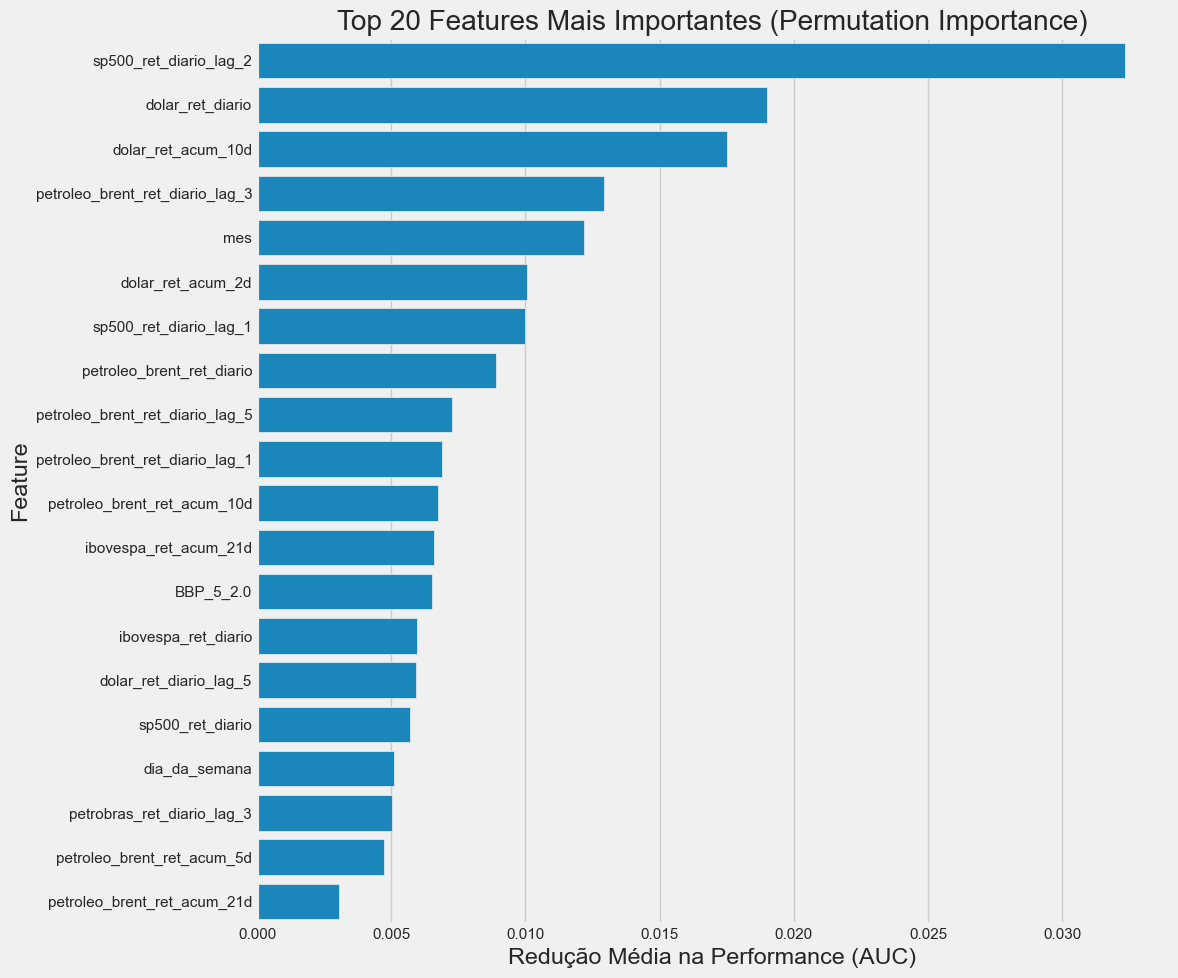

In [19]:
# Usaremos os dados X_treino, y_treino, X_teste, y_teste que já separamos.

print("--- Iniciando Seleção de Atributos com Permutation Importance ---")

# 1. Treinar um modelo LightGBM de baseline com TODAS as features
# Usamos os dados de TREINO para treinar
print("\nTreinando modelo de baseline com todas as features...")
lgbm_baseline = lgb.LGBMClassifier(random_state=42, verbosity=-1)
lgbm_baseline.fit(X_treino, y_treino)

# 2. Calcular a Importância por Permutação
# Usamos os dados de TESTE para avaliar a importância das features em dados não vistos
print("Calculando a importância das features no conjunto de teste...")
result = permutation_importance(
    estimator=lgbm_baseline,
    X=X_teste,
    y=y_teste,
    n_repeats=10,       # Repete o embaralhamento 10 vezes para um resultado mais estável
    scoring='roc_auc',  # Usamos a métrica AUC como nosso critério de importância
    random_state=42,
    n_jobs=-1           # Usa todos os cores da CPU para acelerar
)

# 3. Organizar e Exibir os Resultados
# Criamos um DataFrame com os resultados para facilitar a visualização
df_importancia = pd.DataFrame(
    {'feature': X_treino.columns, 'importance_mean': result.importances_mean}
)
# Ordenamos da mais importante para a menos importante
df_importancia = df_importancia.sort_values(by='importance_mean', ascending=False)

print("\n--- Top 20 Features Mais Importantes ---")
display(df_importancia.head(20))

# 4. Visualizar a Importância das Features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance_mean',
    y='feature',
    data=df_importancia.head(20) # Plotando apenas o top 20
)
plt.title('Top 20 Features Mais Importantes (Permutation Importance)')
plt.xlabel('Redução Média na Performance (AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 🧪 Seleção Final de Features para Modelagem

Com base na análise de **Permutation Importance**, selecionamos as **20 variáveis mais relevantes** para compor o nosso conjunto final de preditores.

---

### 🎯 Critério de Seleção

- As features foram ordenadas pela **redução média na performance (AUC)** ao serem embaralhadas.
- As **20 com maior impacto negativo** na performance do modelo foram selecionadas.
- Essa abordagem prioriza variáveis que de fato **contribuem para a capacidade preditiva** e ajuda a reduzir o risco de overfitting.

---

### 🧾 Resultado

A lista `features_selecionadas` representa as variáveis que serão utilizadas na próxima etapa de **modelagem final**.

✅ Com esse subconjunto enxuto e informativo, seguimos para o treinamento e avaliação de modelos com maior eficiência e interpretabilidade.


In [20]:
# Vamos selecionar as 20 features mais importantes
features_selecionadas = df_importancia.head(20)['feature'].tolist()

print("Features selecionadas para o modelo final:")
print(features_selecionadas)

Features selecionadas para o modelo final:
['sp500_ret_diario_lag_2', 'dolar_ret_diario', 'dolar_ret_acum_10d', 'petroleo_brent_ret_diario_lag_3', 'mes', 'dolar_ret_acum_2d', 'sp500_ret_diario_lag_1', 'petroleo_brent_ret_diario', 'petroleo_brent_ret_diario_lag_5', 'petroleo_brent_ret_diario_lag_1', 'petroleo_brent_ret_acum_10d', 'ibovespa_ret_acum_21d', 'BBP_5_2.0', 'ibovespa_ret_diario', 'dolar_ret_diario_lag_5', 'sp500_ret_diario', 'dia_da_semana', 'petrobras_ret_diario_lag_3', 'petroleo_brent_ret_acum_5d', 'petroleo_brent_ret_acum_21d']


## ⚙️ Aplicação da Seleção de Features no Conjunto de Dados

Com a lista `features_selecionadas` definida, filtramos os DataFrames `X_treino` e `X_teste` para manter somente as variáveis mais importantes.

---

### Objetivos:

- Reduzir a dimensionalidade dos dados para melhorar eficiência computacional.
- Manter apenas as features que mais contribuem para a performance do modelo.
- Facilitar a interpretabilidade e evitar possíveis ruídos no treinamento.

---

### Resultado Esperado:

- `X_treino_selecionado` e `X_teste_selecionado` contêm apenas as 20 variáveis selecionadas.
- A dimensão dos conjuntos reduzida, porém com as variáveis de maior impacto preditivo.

✅ Preparados para o treinamento do modelo final com os dados otimizados.


In [21]:
# 'features_selecionadas' é a lista com os nomes das melhores features que criamos na etapa anterior
# 'X_treino' e 'X_teste' são os DataFrames que contêm TODAS as features

print(f"Usando as {len(features_selecionadas)} features mais importantes para a modelagem.")

X_treino_selecionado = X_treino[features_selecionadas]
X_teste_selecionado = X_teste[features_selecionadas]

print("\nShape de X_treino_selecionado:", X_treino_selecionado.shape)
print("Shape de X_teste_selecionado:", X_teste_selecionado.shape)

Usando as 20 features mais importantes para a modelagem.

Shape de X_treino_selecionado: (2846, 20)
Shape de X_teste_selecionado: (129, 20)


## 🧠 Modelo A – Visão de Longo Prazo

Neste primeiro experimento, treinamos um modelo LightGBM utilizando **todo o histórico de dados disponíveis** no conjunto de treino. O objetivo é capturar padrões de longo prazo na dinâmica do mercado.

---

### ⚙️ Estratégia de Treinamento

- Utilização de **todas as amostras disponíveis** no conjunto de treino.
- Conjunto de teste permanece fixo para comparação posterior com outros modelos.
- Modelo base: `LGBMClassifier`, sem tuning de hiperparâmetros (baseline).
- Métrica principal: **AUC ROC**, além de métricas de classificação padrão (precision, recall, F1-score).

---

### 📊 Resultados do Modelo A

- **Acurácia:** 53%
- **AUC ROC:** 0.5822
- **Observações:**
  - A performance é apenas ligeiramente superior ao acaso (50%).
  - O modelo tem dificuldade especialmente em capturar a classe “Alta” (recall = 0.47).
  - A baixa AUC indica que o modelo não está conseguindo distinguir bem os padrões de subi


In [22]:
# --- Treinando e Avaliando o Modelo A (Longo Prazo) ---
print("\n--- Treinando Modelo A: Visão de Longo Prazo ---")

# 1. Inicializa o modelo LightGBM
lgbm_longo_prazo = lgb.LGBMClassifier(random_state=42, verbosity=-1)

# 2. Treina o modelo com os dados de treino completos
lgbm_longo_prazo.fit(X_treino_selecionado, y_treino)

# 3. Faz previsões no conjunto de teste
y_pred_longo_prazo = lgbm_longo_prazo.predict(X_teste_selecionado)
y_proba_longo_prazo = lgbm_longo_prazo.predict_proba(X_teste_selecionado)[:, 1]

# 4. Avalia a performance
print("\nResultados do Modelo A (Longo Prazo):")
print(classification_report(y_teste, y_pred_longo_prazo, target_names=['Baixa', 'Alta']))
print(f"AUC ROC: {roc_auc_score(y_teste, y_proba_longo_prazo):.4f}")


--- Treinando Modelo A: Visão de Longo Prazo ---

Resultados do Modelo A (Longo Prazo):
              precision    recall  f1-score   support

       Baixa       0.51      0.61      0.55        61
        Alta       0.57      0.47      0.52        68

    accuracy                           0.53       129
   macro avg       0.54      0.54      0.53       129
weighted avg       0.54      0.53      0.53       129

AUC ROC: 0.5822


## 🔍 Modelo B – Visão Recente (Últimos 6 Anos)

Neste segundo experimento, testamos a hipótese de que o comportamento recente do mercado pode conter padrões mais relevantes para o modelo do que o histórico completo. Assim, treinamos o modelo **apenas com dados dos últimos 6 anos**, mantendo o mesmo conjunto de teste para garantir uma comparação justa com o Modelo A.

---

### ⚙️ Estratégia de Treinamento

- Dados de treino foram filtrados para conter apenas os últimos **6 anos de histórico**.
- Conjunto de teste permaneceu **inalterado**, com 129 amostras.
- Modelo: `LGBMClassifier` (sem ajuste de hiperparâmetros).
- Métrica principal: **AUC ROC**, complementada por acurácia e F1-score.

---

### 📊 Resultados do Modelo B

- **Acurácia:** 58%
- **AUC ROC:** 0.5996
- **Observações:**
  - Houve melhora em todas as métricas em relação ao Modelo A.
  - A classe “Alta” apresentou **maior precisão (0.62)**, sugerindo que o modelo recente entende melhor os padrões de alta do Ibovespa.
  - A curva ROC também sugere melhor separação entre classes.

---

### 🧩 Interpretação

O modelo treinado com dados mais recentes apresentou **melhor desempenho geral**, reforçando a ideia de que o mercado mudou e que **padrões históricos mais antigos perderam relevância**.

Esse resultado também valida os achados da EDA, que apontaram alterações estruturais nas correlações do Ibovespa com ativos como Petrobras, Dólar e S&P 500 nos últimos anos.

✅ O Modelo B será considerado o novo baseline para as próximas etapas, como tuning de hiperparâmetros e validação com diferentes janelas temporais.


In [ ]:
# --- Treinando e Avaliando o Modelo B (Recente) ---
print("\n--- Treinando Modelo B: Visão Recente (Últimos 6 Anos) ---")

# 1. Filtra o conjunto de treino para os últimos 3 anos
ponto_de_corte_recente = X_treino_selecionado.index.max() - pd.DateOffset(years=6)
X_treino_recente = X_treino_selecionado[X_treino_selecionado.index >= ponto_de_corte_recente]
y_treino_recente = y_treino.loc[X_treino_recente.index]

print(f"Usando {len(X_treino_recente)} amostras recentes para o treino do Modelo B.")

# 2. Inicializa e treina o modelo
lgbm_recente = lgb.LGBMClassifier(random_state=42, verbosity=-1)
lgbm_recente.fit(X_treino_recente, y_treino_recente)

# 3. Faz previsões no MESMO conjunto de teste para uma comparação justa
y_pred_recente = lgbm_recente.predict(X_teste_selecionado)
y_proba_recente = lgbm_recente.predict_proba(X_teste_selecionado)[:, 1]

# 4. Avalia a performance
print("\nResultados do Modelo B (Recente):")
print(classification_report(y_teste, y_pred_recente, target_names=['Baixa', 'Alta']))
print(f"AUC ROC: {roc_auc_score(y_teste, y_proba_recente):.4f}")


--- Treinando Modelo B: Visão Recente (Últimos 3 Anos) ---
Usando 1566 amostras recentes para o treino do Modelo B.

Resultados do Modelo B (Recente):
              precision    recall  f1-score   support

       Baixa       0.55      0.64      0.59        61
        Alta       0.62      0.53      0.57        68

    accuracy                           0.58       129
   macro avg       0.58      0.58      0.58       129
weighted avg       0.59      0.58      0.58       129

AUC ROC: 0.5996
